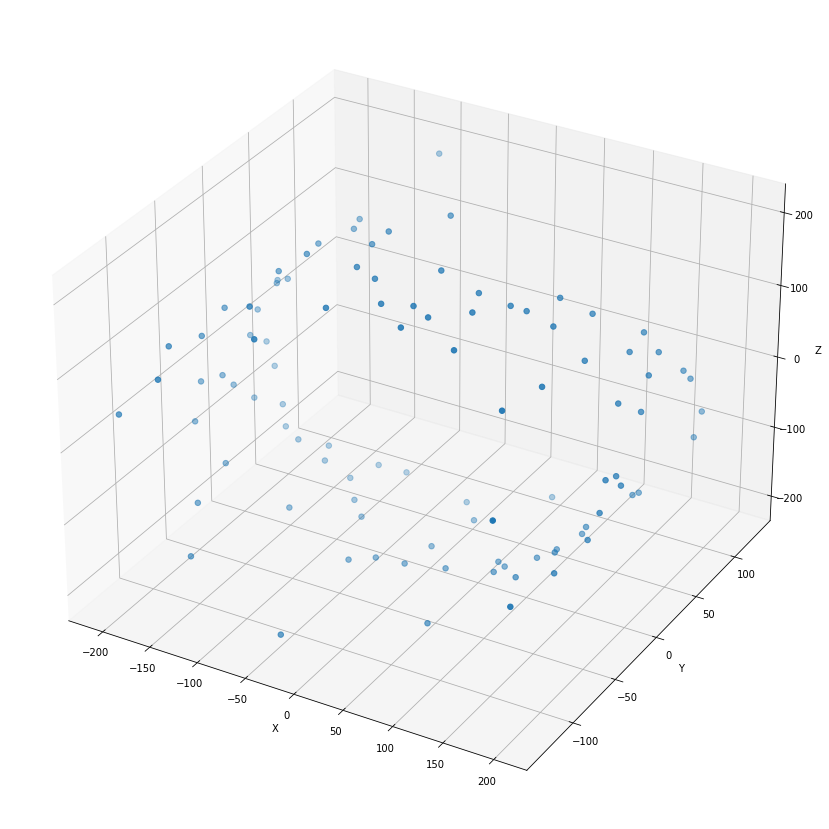

In [2]:
import numpy as np
import matplotlib.pyplot as plt

WSIZE = 960

def rotate_y( theta ):
    r_mat = np.array( [[np.cos(theta), 0.0, np.sin(theta)],
                       [0.0, 1.0, 0.0],
                       [-np.sin(theta), 0.0, np.cos(theta)]] )
    return r_mat

def cam_rotate( e, u, t ):
    z = np.array([(e[0]-t[0]), (e[1]-t[1]), (e[2]-t[2]) ] )

    if( np.sum( np.square(z) ) !=0 ):
        z = z/np.sqrt((np.sum( np.square(z) ) ))
        
    x = np.cross( u, z )
    #print( x )
    if np.sqrt( np.sum( np.square(x) ) )!=0:
        x = x/np.sqrt( np.sum( np.square(x) ) )

    y = np.cross( z, x )
    gl_r = np.vstack( (x, y, z ) )
    #print( gl_r ) 
    #リサイズ
    gl_r = np.append( gl_r, np.zeros( (1, 3) ), axis = 0 )
    gl_r = np.append( gl_r, np.array([[0],[0],[0],[1]] ), axis =1 )
    rot_y  = np.array([[1.0, 0.0, 0.0, 0.0],
                       [0.0, -1.0, 0.0, 0.0],
                       [0.0, 0.0, -1.0, 0.0],
                       [0.0, 0.0, 0.0, 1.0 ]])


    #print( gl_r )
    r = np.dot( rot_y, gl_r )
    return r

def cam_translate( cam_pos ):
    t = np.array([[ 1.0, 0.0, 0.0, -cam_pos[0]],
                  [ 0.0, 1.0, 0.0, -cam_pos[1]],
                  [ 0.0, 0.0, 1.0, -cam_pos[2]],
                  [ 0.0, 0.0, 0.0, 1.0]])
    
    return t


    
#内部パラメータの計算
viewport = np.array([[ WSIZE/2.0, 0.0, 0.0, WSIZE/2.0 ],
                     [ 0.0, -WSIZE/2.0, 0.0, WSIZE/2.0 ],
                     [ 0.0, 0.0, 0.0, 1.0 ]]
                    )
#透視投影変換行列
near = 1.0
far = 300.0
top = 1.0/np.sqrt( 3.0 )
bottom = -1.0/np.sqrt( 3.0 )
left = -1.0/np.sqrt( 3.0 )
right = 1.0/np.sqrt( 3.0 )

perspective = np.array([[(2.0*near)/(right-left), 0.0, (right+left)/(right-left), 0.0 ],
                        [0.0, (2.0*near)/(top-bottom), (top+bottom)/(top-bottom), 0.0],
                        [0.0, 0.0, -(far+near)/(far-near), -(2.0*far*near)/(far-near)],
                        [0.0, 0.0, -1.0, 0.0]])

rot_y  = np.array([[1.0, 0.0, 0.0, 0.0],
                   [0.0, -1.0, 0.0, 0.0],
                   [0.0, 0.0, -1.0, 0.0],
                   [0.0, 0.0, 0.0, 1.0 ]])

gl_viewport = np.dot( viewport, perspective )
intrinsic = np.dot( gl_viewport, rot_y )
#print( intrinsic[:, :3] )
#内部パラメータの出力
#np.savetxt( './simulation_data/intrinsicParameters.txt', intrinsic[:, :3 ] , fmt ='%.2f')

#ex_base = './simulation_data/extrinsicParameters_world/'
#初期のカメラの視点
init_pos =np.array( [0.0, 0.0, -200.0]) 
number_of_frames = 100
theta_all = np.array( range(number_of_frames) )
theta_all = theta_all*(np.pi/(number_of_frames/2))
file_count = 0

#最初のカメラの座標系＝世界座標系となるように変換
P_prev = np.array([ [-1.0, 0.0, 0.0, 0.0], [0.0, -1.0, 0.0, 0.0], [0.0, 0.0, 1.0, -200.0], [0.0, 0.0, 0.0, 1.0]] )

cam_pos_all = np.zeros( (theta_all.shape[0], 3 ) )
for theta in theta_all:
    r_mat = rotate_y( theta )
    #カメラ位置（描画の際に必要）
    cam_pos = np.dot( r_mat, init_pos )
    cam_pos_all[ file_count, : ] = cam_pos
    #回転行列
    e = cam_pos
    u = np.array( [ 0.0, 1.0, 0.0 ] )
    t = np.array( [ 0.0, 0.0, 0.0 ] )
    rotate = cam_rotate( e, u, t )
    
    #print( rotate )

    #並進行列
    translate = cam_translate( cam_pos )
    #カメラの外部パラメータ
    extrinsic = np.dot( rotate, translate )    
    #print( extrinsic[:3, :] )
    #最初のカメラの座標系＝世界座標系となるように変換
    extrinsic = np.dot( extrinsic, P_prev )
    #外部パラメータを保存
    #ex_filename = ex_base + '{:0=4}.txt'.format(file_count)
    #np.savetxt( ex_filename, extrinsic[ :3, : ] , fmt ='%.2f')
    file_count = file_count + 1

cam_pos_all_with_noise = np.zeros((cam_pos_all.shape[0], cam_pos_all.shape[1]))

mu, sigma_1, sigma_2 = 0, 5, 50# mean and standard deviation
#mu, sigma = 0, 0# mean and standard deviation

#for i in range(cam_pos_all.shape[0]):
#    for j in range(cam_pos_all.shape[1]):
#        s = np.random.normal(mu, sigma)
#        cam_pos_all_with_noise[i][j] = cam_pos_all[i][j] + s

cam_pos_all_with_noise[:, 0] = cam_pos_all[:, 0] +  np.random.normal(mu, sigma_1, cam_pos_all.shape[0])
cam_pos_all_with_noise[:, 1] = cam_pos_all[:, 1] +  np.random.normal(mu, sigma_2, cam_pos_all.shape[0])
cam_pos_all_with_noise[:, 2] = cam_pos_all[:, 2] +  np.random.normal(mu, sigma_1, cam_pos_all.shape[0])

#opengl で描画に必要なので，保存
#np.savetxt( './cam_position.txt', cam_pos_all_with_noise, fmt ='%.2f' )

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cam_pos_all_with_noise[:, 0], cam_pos_all_with_noise[:, 1], cam_pos_all_with_noise[:, 2], marker='o', s=30)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

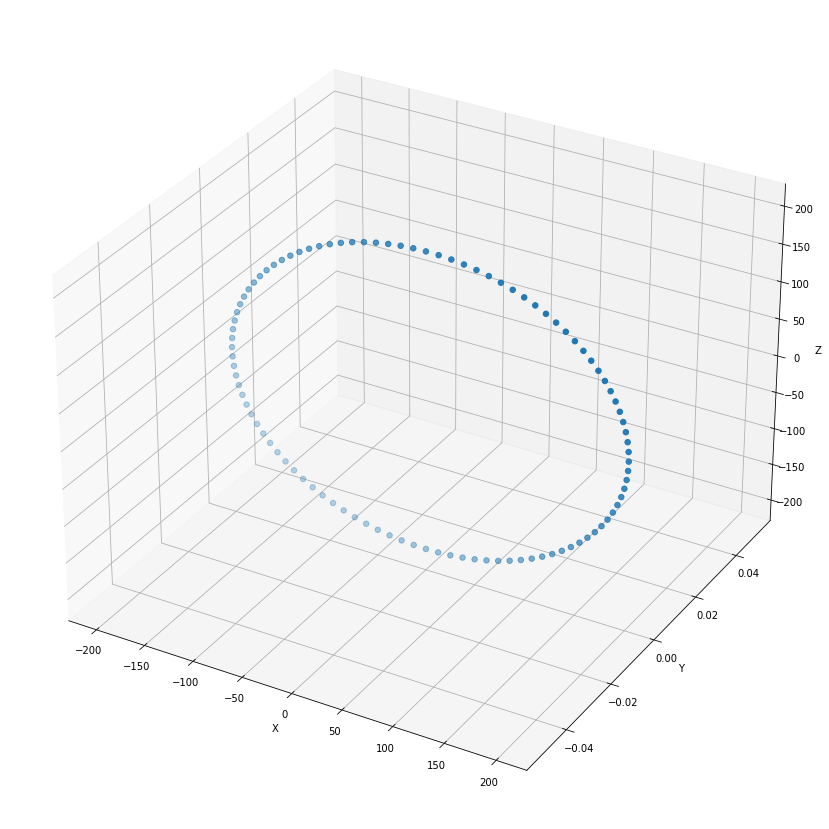

In [3]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cam_pos_all[:, 0], cam_pos_all[:, 1], cam_pos_all[:, 2], marker='o', s=30)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

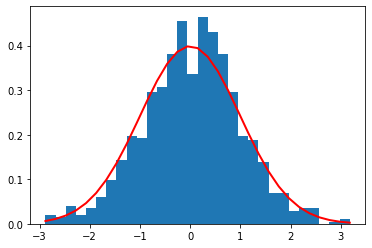

In [9]:
mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
abs(mu - np.mean(s))
abs(sigma - np.std(s, ddof=1))
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()